In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("dataset2_l4.txt")
print("{} записів, {} полів".format(*df.shape))
df.head()

8250 записів, 11 полів


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [5]:
df = df.drop(columns=["Class"])
print(f"Атрибути: {list(df.columns)}")

Атрибути: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10']


In [103]:
kmeans = KMeans(n_clusters=2, init='random', random_state=42, n_init=10)

kmeans.fit(df)

centroids = kmeans.cluster_centers_

print("Координати центрів кластерів:")
print(centroids)

Координати центрів кластерів:
[[ 6.46734489e-03 -9.39418633e-03 -1.46817589e-02 -6.73827300e-03
   1.59361355e-02  8.24405298e-03 -8.38680010e-03  8.58500497e-03
   4.62652152e-03 -2.41405819e-03]
 [ 0.00000000e+00  3.86000000e+02  5.00000000e+01  1.68104000e-01
   0.00000000e+00  5.30000000e+01  8.30000000e+01  2.75032000e-01
   4.40000000e+01  6.38020000e-01]]


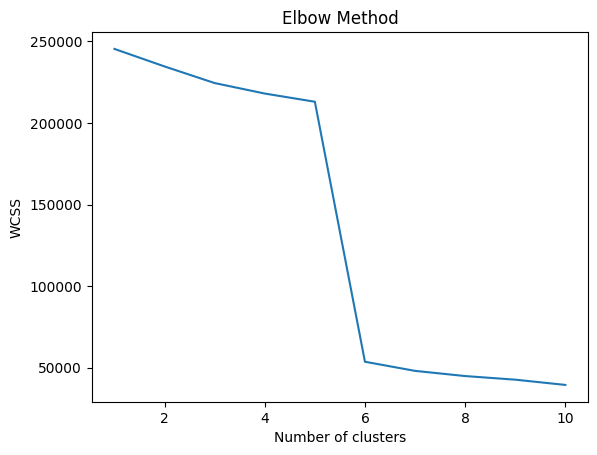

In [104]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=88, init="random")
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

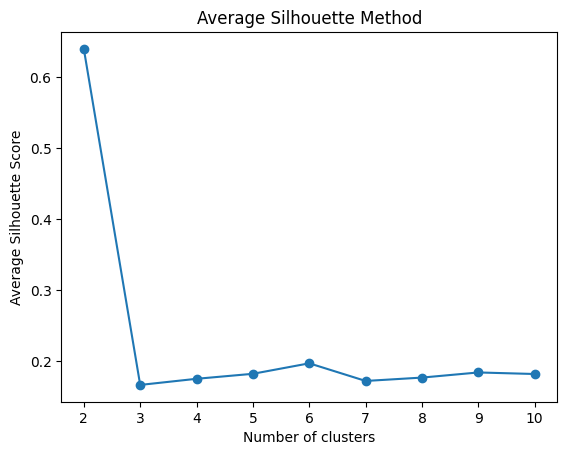

In [105]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='random', max_iter=300, n_init=10, random_state=1444)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Average Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

In [106]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split

def prediction_strength(X, k, test_size=0.2, random_state=1444):

    X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)

    kmeans_train = KMeans(n_clusters=k, random_state=random_state, n_init=10, init='random')
    kmeans_train.fit(X_train)
    labels_train = kmeans_train.labels_

    test_labels_pred = kmeans_train.predict(X_test)

    kmeans_test = KMeans(n_clusters=k, random_state=random_state, n_init=10, init='random')
    kmeans_test.fit(X_test)
    labels_test = kmeans_test.labels_

    centroids_train = kmeans_train.cluster_centers_
    centroids_test = kmeans_test.cluster_centers_

    closest_clusters, _ = pairwise_distances_argmin_min(centroids_test, centroids_train)

    clusters_strengths = []

    n = len(labels_test)

    train_comembership = np.zeros((n, n), dtype=int)

    for i in range(n):
          for j in range(n):
              if labels_train[i] == labels_train[j]:
                  train_comembership[i, j] = 1


    for cluster_id in range(k):

        cluster_size = len(np.where(labels_test==cluster_id)[0])

        test_comembership = np.zeros((n, n), dtype=int)

        for i in range(n):
          for j in range(n):
              if labels_test[i] == labels_test[j] == cluster_id and i != j:
                  test_comembership[i, j] = 1

        sum = np.sum((train_comembership == 1) & (test_comembership == 1))

        clusters_strengths.append(sum/(cluster_size*(cluster_size-1)))

    return min(clusters_strengths)

from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=8, random_state=0, cluster_std=0.5)

100%|██████████| 9/9 [02:31<00:00, 16.87s/it]


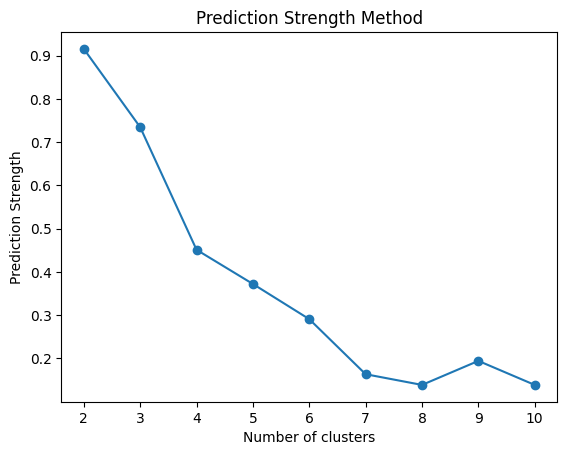

In [90]:
from tqdm import tqdm

prediction_strengths = []

range_n_clusters = range(2, 11)
for n_clusters in tqdm(range_n_clusters):
    ps = prediction_strength(df, k=n_clusters, random_state=1444)
    prediction_strengths.append(ps)

plt.plot(range_n_clusters, prediction_strengths, marker='o')
plt.title('Prediction Strength Method')
plt.xlabel('Number of clusters')
plt.ylabel('Prediction Strength')
plt.show()

In [100]:
k = 2
best_silhouette_score = -1
best_kmeans = None

for i in tqdm(range(20)):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1)
    kmeans.fit(df)

    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df, labels)

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_kmeans = kmeans

print(f"Найкращий коефіцієнт силуету: {best_silhouette_score}")
print(f"Центроїди найкращих кластерів:\n{best_kmeans.cluster_centers_}")


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

Найкращий коефіцієнт силуету: 0.9904961296738412
Центроїди найкращих кластерів:
[[ 6.46734489e-03 -9.39418633e-03 -1.46817589e-02 -6.73827300e-03
   1.59361355e-02  8.24405298e-03 -8.38680010e-03  8.58500497e-03
   4.62652152e-03 -2.41405819e-03]
 [ 0.00000000e+00  3.86000000e+02  5.00000000e+01  1.68104000e-01
   0.00000000e+00  5.30000000e+01  8.30000000e+01  2.75032000e-01
   4.40000000e+01  6.38020000e-01]]


Центроїди кластерів:
[[ 6.46734489e-03 -9.39418633e-03 -1.46817589e-02 -6.73827300e-03
   1.59361355e-02  8.24405298e-03 -8.38680010e-03  8.58500497e-03
   4.62652152e-03 -2.41405819e-03]
 [ 0.00000000e+00  3.86000000e+02  5.00000000e+01  1.68104000e-01
   0.00000000e+00  5.30000000e+01  8.30000000e+01  2.75032000e-01
   4.40000000e+01  6.38020000e-01]]


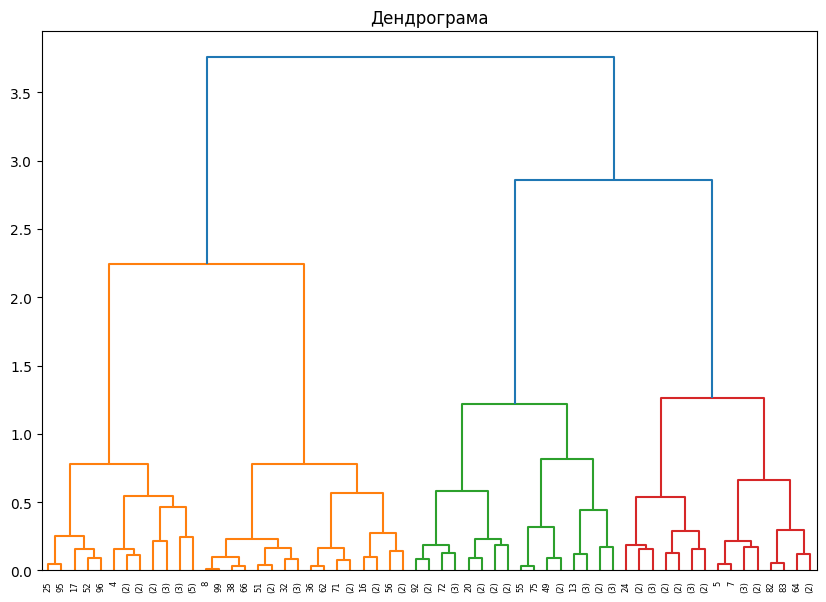

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

k = 2

agg_clustering = AgglomerativeClustering(n_clusters=k)
labels = agg_clustering.fit_predict(df)

centroids = np.array([df[labels == i].mean(axis=0) for i in range(k)])

print(f"Центроїди кластерів:\n{centroids}")

linked = linkage(X, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Дендрограма')
plt.show()